 # Provable  Multiple Linear Regression Solver
 
For this particular tutorial, we will build a Multiple Linear Regression algorithm from scratch and use it to <b>forecast the projected the 7-day lifetime repayments for  AAVE's WETH Pool</b>. Toward the end of the tutorial, we will convert the data & model to Cairo enabling us to make the entire Multiple Regression Solver as well as the AAVE's forecasts to be <b>fully Provable and Verifiable. </b>
### Overview & methodology
In many financial business applications, a vast number of problems can be modeled using <b>Multiple Linear Regression.</b> As we step into the on-chain ProvableML domain, these traditional algorithms may still be essential in addressing forecasting and prediction-related business problems. Interestingly, these may prove to be actually advantageous in on-chain environments as they are relatively interpretable, lightweight and cost-efficient.

The most common method for computing MLR includes the use of pseudo-inverse or  SVD (Singular value decomposition), which can be far more complex to implement than the problem being worked on often times. Hence, the next common approach often preferred are gradient-based methods.  These are perfect for large datasets, but they too can be excessive due to the intensive iterative approach they take to approximate gradients; which in the context of on-chain environments can be fairly expensive. 

<b>This repo presents an intuitive a closed-form (non gradient based) approach to computing MLR gradients to allow builders and end-users to interact with MLR systems with ease and transparency. </b>

The Multiple Linear regression Solver works in three components:
1. Decorrelates x features from one another (most intensive part)
2. Computes the exact gradients between each decorrelated x feature and target y variables in one step
3. Performs predictions and forecasts using the computed gradients

#### Provability and Verifiability
<b>The key benefit of this Multiple Linear Regression Solver lies in its commitment to <u>Provability and Verifiability</u>. By integrating it into Cairo using the Orion Framework, we allow the entire MLR system to become inherently provable through STARKs, ensuring unparalleled transparency and trustworthiness. This enables every inference of the model construction, execution and prediction to be easily proved using LambdaClass STARK Prover. </b>


##  Import necessary libs & prepare dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import r2_score

In [2]:
# dataset pulled from https://app.aavescan.com/  
df_main= pd.read_csv('AAVE-V3-weth.csv')
df_main.drop('Unnamed: 0', axis=1, inplace=True)

In [3]:
# reverse order as the row 1 illustrates the most recent datapoint in terms of date
df_main= df_main.iloc[::-1]

In [4]:
df_main.head()

,accruedToTreasury,availableLiquidity,lifetimeFlashLoans,lifetimeLiquidity,lifetimeReserveFactorAccrued,totalLiquidityAsCollateral,totalScaledVariableDebt,lifetimeRepayments,variableBorrowRate
30,9.330000e+18,7.400000e+22,1.240000e+23,2.040000e+24,5.500000e+20,1.190000e+24,2.870000e+23,7.640000e+23,3.370000e+25
29,1.340000e+19,7.450000e+22,1.240000e+23,2.050000e+24,5.500000e+20,1.190000e+24,2.870000e+23,7.640000e+23,3.370000e+25
28,1.740000e+19,8.020000e+22,1.240000e+23,2.070000e+24,5.500000e+20,1.190000e+24,2.880000e+23,7.650000e+23,3.320000e+25
27,2.120000e+19,9.590000e+22,1.280000e+23,2.120000e+24,5.500000e+20,1.240000e+24,2.860000e+23,7.700000e+23,3.180000e+25
26,1.660000e+17,1.000000e+23,1.410000e+23,2.150000e+24,5.750000e+20,1.280000e+24,2.870000e+23,7.730000e+23,3.150000e+25


## Preparing the Features and Labels

Now that we have prepared our AAVE dataset, we will use the features to forecast the <b>lifetime Repayments 7 days in advance</b>. In order to achieve this, we take the lifetime Repayments column and replicate it into a new column whilst shifting the column data upwards by 7 spots. This, will allow us to use this shifted column as our y label and the rest of the data as our X features.



In [5]:
#Since Most of the df values are in wei we devide all values by a fixed factor to make the data easy to work with.
# Hence, we devide by 1e+22 to have values in thousands of ETH. 
# This will also prevent overflow as we work with 16x16 fixed point numbers in orion as we transition to cairo in later stages 
factor = 1e+22
df_main = df_main/factor

In [6]:
df= df_main.copy()

In [7]:
days_to_forecast = -7
df['lifetimeRepayments_7day_forecast'] = df[['lifetimeRepayments']].shift(days_to_forecast) 
df = df[0:days_to_forecast]

In [8]:
df.head()

,accruedToTreasury,availableLiquidity,lifetimeFlashLoans,lifetimeLiquidity,lifetimeReserveFactorAccrued,totalLiquidityAsCollateral,totalScaledVariableDebt,lifetimeRepayments,variableBorrowRate,lifetimeRepayments_7day_forecast
30,0.000933,7.40,12.4,204.0,0.0550,119.0,28.7,76.4,3370.0,77.4
29,0.001340,7.45,12.4,205.0,0.0550,119.0,28.7,76.4,3370.0,77.4
28,0.001740,8.02,12.4,207.0,0.0550,119.0,28.8,76.5,3320.0,77.5
27,0.002120,9.59,12.8,212.0,0.0550,124.0,28.6,77.0,3180.0,77.6
26,0.000017,10.00,14.1,215.0,0.0575,128.0,28.7,77.3,3150.0,78.0


In [9]:
#Drop the y label from dataframe
features = df.drop(['lifetimeRepayments_7day_forecast'], axis=1)
#setting our y label
target = df['lifetimeRepayments_7day_forecast']


# convert data to numpy format
X_original = features.to_numpy()
Y_original = target.to_numpy()

print(X_original.shape)
print(Y_original.shape)

(24, 9)
(24,)


## Normalize the data
Normalize the data so that all the features values are between 0-1

In [10]:
def normalize_data(original_data):
    data_min = np.min(original_data, axis=0)
    data_max = np.max(original_data, axis=0)
    data_range = data_max - data_min
    data_normalized =  (original_data - data_min) / data_range
    
    return data_normalized
    

In [11]:
# normalize the data 
X_normalized= normalize_data(X_original)
y_normalized= normalize_data(Y_original)

print('Features max value:', X_normalized.max())
print('Features min value:', X_normalized.min())
print('Labels max value:', y_normalized.max())
print('Labels min value:', y_normalized.min())


Features max value: 1.0
Features min value: 0.0
Labels max value: 1.0
Labels min value: 0.0


# Main Multiple Linear Regression algorythm

In [12]:
def transpose_and_add_bias(feature_data):
    #transpose the data
    transposed_data= feature_data.T
    #add bias term
    transposed_data_with_bias = np.vstack((transposed_data, np.ones(transposed_data.shape[1])))
    
    return transposed_data_with_bias

#### Decorelate the x features
It's <b>very important</b> to notice that as we decorrelate the X features, only the last feature row will be fully <b>orthogonal</b>. The rest of the features are  decorrelated from one another but <b>are not fully orthogonal to each other</b>. This is done to save on computational cost and make the algorythm more efficient. This will enable us to calculate the following feature gradients much easier and quicker, than if we were to fully orthogonalize all the features and then compute the gradients.

Later when we compute the gradients we will start from the last fully orthogonalised feature values and walk backwards to calculate the correponding gradinets, whilst removing their component from the y variable. 

In [13]:
def decorrelate_features(feature_data):

    # Make copy of input matrix
    x_temp = feature_data.copy()
    
    # Get number of features
    feature_rows = feature_data.shape[0]
    
    # Decorrelate features
    for i in range(feature_rows):
        feature_squared = np.sum(x_temp[i]**2)
        for j in range(i+1, feature_rows):
            feature_cross_prod = np.sum(x_temp[i] * x_temp[j])
            if feature_squared == 0:
                print('Warning, division by zero encountered and handled')
                feature_squared = 1e-8 
            feature_grad = feature_cross_prod / feature_squared
            x_temp[j] -= feature_grad * x_temp[i]
            
    decorelated_x_vals = x_temp

    return decorelated_x_vals


#### Calculating Gradients

In [14]:
def calculate_gradients(decorelated_x_vals, y_values, original_x_features):
  
    # Initialize gradients array
    # Make copy of input matrix
    y_temp = y_values.copy()
    feature_rows = decorelated_x_vals.shape[0]
    gradients = np.zeros(feature_rows)

    # Calculate gradients
    for i in range(feature_rows-1, -1, -1):
        prod = np.sum(y_temp * decorelated_x_vals[i])
        squared = np.sum(decorelated_x_vals[i] * decorelated_x_vals[i])
        if squared == 0:
            print('Warning, division by zero encountered and handled')
            squared = 1e-8

        gradients[i] = prod / squared
        y_temp -= gradients[i] * original_x_features[i]
    

    return gradients

In [15]:
X_normalized_transposed_with_bias = transpose_and_add_bias(X_normalized)

print("Training data shapes:")
print("X_normalized:", X_normalized_transposed_with_bias.shape)
print("y_normalized:", y_normalized.shape)

Training data shapes:
X_normalized: (10, 24)
y_normalized: (24,)


In [16]:
decorrelated_X_features = decorrelate_features(X_normalized_transposed_with_bias)

In [17]:
gradient_values = calculate_gradients(decorrelated_X_features, y_normalized, X_normalized_transposed_with_bias )


In [18]:
real_gradient_values_reversed = np.flip(gradient_values)
print('All regression coefficient: ', real_gradient_values_reversed )

All regression coefficient:  [-1.27062243  1.15931271  0.173401   -0.31112069  1.09338439  0.93959362
 -1.12956438 -0.08371113  1.18734043  0.3425375 ]


# Reconstructing the y labels using the calculated gradients and X feature data

In [19]:
def denormalize_data(original_data,normalized_data):
    data_min = np.min(original_data)
    data_max = np.max(original_data)
    data_range = data_max - data_min
    
    denormalize_data = ( normalized_data * data_range) + data_min
    return denormalize_data

R^2 score (denormalized): 0.9968099033369738


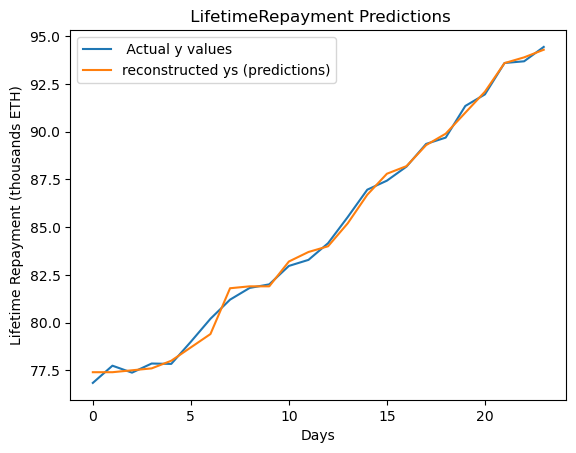

In [20]:
y_pred_norm = gradient_values @ X_normalized_transposed_with_bias #prediction#
reconstructed_y = denormalize_data(Y_original,y_pred_norm) 
# Plot the denormalized y values
plt.figure(2)
plt.title(" LifetimeRepayment Predictions")
plt.plot(reconstructed_y )
plt.plot(Y_original)
plt.legend([" Actual y values", "reconstructed ys (predictions)"])
plt.xlabel('Days')
plt.ylabel('Lifetime Repayment (thousands ETH)')

# Calculate R^2 score for denormalized prediction
accuracy_denormalized = r2_score(Y_original, reconstructed_y)
print("R^2 score (denormalized):", accuracy_denormalized)

# The upcoming 7 day Total lifetime repayments forecasts for AAVE's WETH Pool

In [21]:
df_forecast = df_main[-7:]
df_forecast_data = df_forecast.to_numpy()

In [22]:
X_min = np.min(X_original, axis=0)
X_max = np.max(X_original, axis=0)
X_range = X_max - X_min
df_forecast_data_normalized =    (df_forecast_data - X_min) / X_range
# print(df_forecast_data_normalized.shape)

In [23]:
# tranpose the matrix and add ones 
df_forecast_data_normalized_transposed= df_forecast_data_normalized.T
df_forecast_data_normalized_transposed_with_bias = np.vstack((df_forecast_data_normalized_transposed, np.ones(df_forecast_data_normalized_transposed.shape[1])))
print("Training data shapes:")
print("X_normalized:", df_forecast_data_normalized_transposed.shape)
print("y_normalized:", df_forecast_data_normalized_transposed_with_bias.shape)

Training data shapes:
X_normalized: (9, 7)
y_normalized: (10, 7)


In [24]:
forecast_normalized = gradient_values @ df_forecast_data_normalized_transposed_with_bias
for i in range(len(forecast_normalized)):
    print(i,forecast_normalized[i])

0 1.0782944838728898
1 1.1357059848525208
2 1.1665048712468642
3 1.193423550976403
4 1.2455779743568984
5 1.3032904853814864
6 1.3668000624508785


In [25]:
#denormalize forecast
Y_min = np.min(Y_original, axis=0)
Y_max = np.max(Y_original, axis=0)
Y_range = Y_max - Y_min

forecast_pred =  (forecast_normalized * Y_range) + Y_min
# # print(forecast_pred)
for i in range(len(forecast_pred)):
    if i==0:
        print("Tomorrow's Lifetime Repayment from Weth pool Forecast: ",forecast_pred[i])
    else:
        print('Day',i+1,'Lifetime Repayment from Weth pool Forecast',forecast_pred[i])
        

Tomorrow's Lifetime Repayment from Weth pool Forecast:  95.62317677745183
Day 2 Lifetime Repayment from Weth pool Forecast 96.5934311440076
Day 3 Lifetime Repayment from Weth pool Forecast 97.113932324072
Day 4 Lifetime Repayment from Weth pool Forecast 97.5688580115012
Day 5 Lifetime Repayment from Weth pool Forecast 98.45026776663158
Day 6 Lifetime Repayment from Weth pool Forecast 99.42560920294711
Day 7 Lifetime Repayment from Weth pool Forecast 100.49892105541984


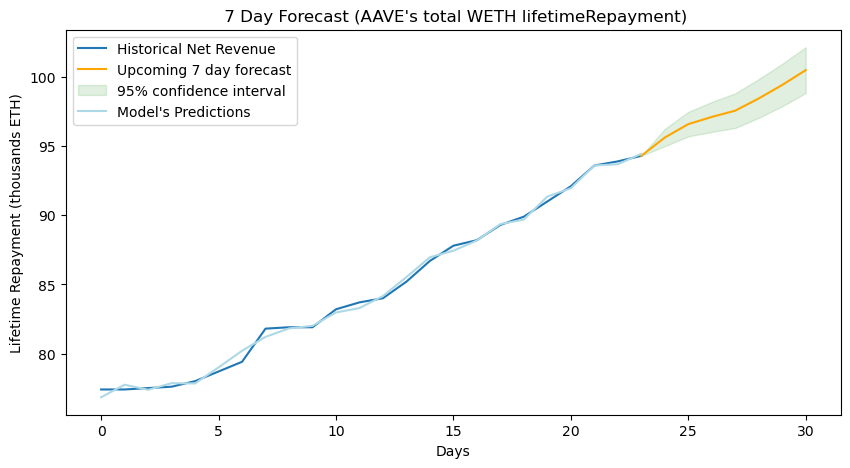

In [26]:
forecast_plot_data = np.insert(forecast_pred, 0, Y_original[-1])

# Calculate expanding confidence intervals
residual = Y_original - reconstructed_y
stderr = np.std(residual)
z_score = 1.96 # z-score for 95% CI
intervals = z_score *stderr * np.sqrt(np.arange(len(forecast_plot_data)))


# Creating the plot
plt.figure(figsize=(10, 5))
plt.plot(Y_original , label='Historical lifetime repayments')
plt.plot(len(Y_original)-1 + np.arange(len(forecast_plot_data)), forecast_plot_data , color='orange', label='Upcoming 7 day forecast')
plt.fill_between(len(Y_original)-1 + np.arange(len(forecast_plot_data)),  
                 (forecast_plot_data - intervals),
                 (forecast_plot_data + intervals),
                 alpha=0.12,
                color='green',
                label='95% confidence interval')


plt.plot(reconstructed_y ,  label="Model's Predictions", color='lightblue')
# Adding labels and title
plt.xlabel('Days')
plt.ylabel('Lifetime Repayment (thousands ETH)')
plt.title(" 7 Day Forecast (AAVE's total WETH lifetimeRepayment)")
plt.legend()

# Display the plot
plt.show()

# Transition to Cairo
## Create a scarb project

Scarb is the Cairo package manager specifically created to streamline our Cairo and Starknet development process. You can find all information about Scarb and Cairo installation here

In [27]:
! scarb new multiple_linear_regression_aave

Created `multiple_linear_regression_aave` package.


In [28]:
!echo -n > multiple_linear_regression_aave/src/lib.cairo

A new project folder will be created for you and make sure to replace the content in Scarb.toml file with the following code:
```toml
[package]
name = "multiple_linear_regresion"
version = "0.1.0"


[dependencies]
orion = { git = "https://github.com/gizatechxyz/onnx-cairo" }

[scripts]
test = "scarb cairo-test -f multiple_linear_regression_test"
```

In [29]:
# add reference modules to help our code compile at the end
%%writefile -a src/lib.cairo 
mod test;
mod data_preprocessing;
mod helper_functions;
mod datasets;
mod model;

SyntaxError: invalid syntax (252576425.py, line 3)


## Generate Cairo files

Now, we will transition our model to cairo. We will start by converting the the X features and Y labels to FP16x16 tensors numbers. 

In [30]:
# Convert the original data to Cairo 


def generate_cairo_files(data, name, folder_name):
    
    os.makedirs(f'multiple_linear_regression_aave/src/datasets/{folder_name}', exist_ok=True)
    with open(os.path.join('multiple_linear_regression_aave/src/datasets', f'{folder_name}', f"{name}.cairo"), "w") as f:
            f.write(
                "use array::ArrayTrait;\n" +
                "use orion::numbers::fixed_point::implementations::fp16x16::core::{FP16x16Impl, FP16x16PartialEq };\n" +
                "use orion::operators::tensor::{Tensor, TensorTrait, FP16x16Tensor};\n" +
                "use orion::numbers::{FP16x16, FixedTrait};\n\n" +
                "fn {0}() ->  Tensor<FP16x16>  ".format(name) + "{\n" +
                "    let tensor = TensorTrait::<FP16x16>::new( \n"
            )
            
            if len(data.shape)>1:
                f.write("    shape: array![{0},".format(data.shape[0]))
                f.write("{0}].span(),\n".format(data.shape[1]))
                f.write(
                    "    data: array![ \n"
                )
            if len(data.shape)==1:
                f.write("    shape: array![{0}].span(),\n".format(data.shape[0]))
                f.write(
                    "    data: array![ \n"
                )
            for val in np.nditer(data.flatten()):
                f.write("    FixedTrait::new({0}, {1} ),\n".format(abs(int(val * 2**16)), str(val < 0).lower()))
            f.write(
                "].span() \n \n" +
                ");\n\n"+
                "return tensor; \n"+
                "}"
            )
    with open(os.path.join('multiple_linear_regression_aave/src/datasets', f'{folder_name}.cairo'), 'a') as f:
        f.write(f"mod {name};\n")

In [31]:
generate_cairo_files(X_original, 'aave_x_features', 'aave_data')
generate_cairo_files(Y_original, 'aave_y_labels', 'aave_data')


In [32]:
generate_cairo_files(df_forecast_data, 'aave_weth_revenue_data_input', 'user_inputs_data')

In [33]:
# add reference modules to help our code compile
! touch multiple_linear_regression_aave/src/datasets.cairo

In [34]:
%%writefile multiple_linear_regression_aave/src/datasets.cairo
mod aave_data;
mod user_inputs_data;

Overwriting multiple_linear_regression_aave/src/datasets.cairo


In [35]:
! touch multiple_linear_regression_aave/src/datasets/aave_data.cairo

In [36]:
%%writefile multiple_linear_regression_aave/src/datasets/aave_data.cairo
mod aave_x_features;
mod aave_y_labels;

Overwriting multiple_linear_regression_aave/src/datasets/aave_data.cairo


In [37]:
! touch multiple_linear_regression_aave/src/datasets/user_inputs_data.cairo

In [38]:
%%writefile multiple_linear_regression_aave/src/datasets/user_inputs_data.cairo
mod aave_weth_revenue_data_input;

Overwriting multiple_linear_regression_aave/src/datasets/user_inputs_data.cairo


## Helper functions 

We add some helper functions to make it easier to construct our MLR model

In [39]:
! touch multiple_linear_regression_aave/src/helper_functions.cairo

In [40]:
%%writefile multiple_linear_regression_aave/src/helper_functions.cairo

use debug::PrintTrait;
use array::{ArrayTrait, SpanTrait};
use orion::operators::tensor::{
    Tensor, TensorTrait, FP16x16Tensor, U32Tensor, U32TensorAdd, FP16x16TensorSub, FP16x16TensorAdd,
    FP16x16TensorDiv, FP16x16TensorMul
};

use orion::numbers::{FP16x16, FixedTrait};

// retrieves row data by index in a 2D tensor
fn get_tensor_data_by_row(tensor_data: Tensor<FP16x16>, row_index: u32,) -> Tensor<FP16x16> {
    let column_len = *tensor_data.shape.at(1); //13
    // crete new array
    let mut result = ArrayTrait::<FP16x16>::new();
    // loop through the x values and append values 
    let mut i: u32 = 0;
    loop {
        if i >= column_len {
            break ();
        }
        result.append(tensor_data.at(indices: array![row_index, i].span()));
        i += 1;
    };
    let resultant_tensor = TensorTrait::<
        FP16x16
    >::new(array![column_len].span(), data: result.span());
    return resultant_tensor;
}


// transposes tensor
fn transpose_tensor(tensor_data: Tensor<FP16x16>) -> Tensor<FP16x16> {
    let tensor_transposed = tensor_data.transpose(axes: array![1, 0].span());
    return tensor_transposed;
}

fn calculate_mean(tensor_data: Tensor<FP16x16>) -> FP16x16 {
    let tensor_size = FixedTrait::<FP16x16>::new_unscaled(tensor_data.data.len(), false);
    let cumulated_sum = tensor_data.cumsum(0, Option::None(()), Option::None(()));
    let sum_result = cumulated_sum.data[tensor_data.data.len() - 1];
    let mean = *sum_result / tensor_size;
    return mean;
}

// Calculates the R-Squared score between two tensors.
fn calculate_r_score(Y_values: Tensor<FP16x16>, Y_pred_values: Tensor<FP16x16>) -> FP16x16 {
    let mut Y_values_ = Y_values;
    let mean_y_value = calculate_mean(Y_values);
    // creating the appropriate tensor shapes and empty arrays to populate values into
    let mut squared_diff_shape = array::ArrayTrait::new();
    squared_diff_shape.append(Y_values.data.len());
    let mut squared_diff_vals = array::ArrayTrait::new();
    let mut squared_mean_diff_shape = array::ArrayTrait::new();
    squared_mean_diff_shape.append(Y_values.data.len());
    let mut squared_mean_diff_vals = array::ArrayTrait::new();

    let mut i: u32 = 0;

    loop {
        match Y_values_.data.pop_front() {
            Option::Some(y_value) => {
                let diff_pred = *y_value - *Y_pred_values.data.at(i);
                let squared_diff = diff_pred * diff_pred;
                squared_diff_vals.append(squared_diff);

                let diff_mean = *y_value - mean_y_value;
                let squared_mean_diff = diff_mean * diff_mean;
                squared_mean_diff_vals.append(squared_mean_diff);
                i += 1;
            },
            Option::None(_) => { break; }
        }
    };

    let squared_diff_tensor = TensorTrait::<
        FP16x16
    >::new(squared_diff_shape.span(), squared_diff_vals.span());
    let squared_mean_diff_tensor = TensorTrait::<
        FP16x16
    >::new(squared_mean_diff_shape.span(), squared_mean_diff_vals.span());
    let sum_squared_diff = squared_diff_tensor.cumsum(0, Option::None(()), Option::None(()));
    let sum_squared_mean_diff = squared_mean_diff_tensor
        .cumsum(0, Option::None(()), Option::None(()));
    let r_score = FixedTrait::new_unscaled(1, false)
        - *sum_squared_diff.data.at(Y_values.data.len() - 1)
            / *sum_squared_mean_diff.data.at(Y_values.data.len() - 1);

    return r_score;
}


// computes the x_min, x_max and x_range. Used for helping in normalizing and denormalizing user inputed values operations
fn normalize_user_x_inputs(
    x_inputs: Tensor<FP16x16>, original_x_values: Tensor<FP16x16>
) -> Tensor<FP16x16> {
    let mut x_inputs_normalized = TensorTrait::<
        FP16x16
    >::new(shape: array![1].span(), data: array![FixedTrait::new(10, false)].span());

    let mut x_min = ArrayTrait::<FP16x16>::new();
    let mut x_max = ArrayTrait::<FP16x16>::new();
    let mut x_range = ArrayTrait::<FP16x16>::new();
    let mut result = ArrayTrait::<FP16x16>::new();

    if original_x_values.shape.len() > 1 {
        let transposed_tensor = original_x_values.transpose(axes: array![1, 0].span());
        let data_len = *transposed_tensor.shape.at(0); //13
        // loop through each row calculating the min, max and range row values for each feature columns
        let mut i: u32 = 0;
        loop {
            if i >= data_len {
                break ();
            }
            let mut transposed_tensor_row = get_tensor_data_by_row(transposed_tensor, i);
            x_min.append(transposed_tensor_row.min_in_tensor());
            x_max.append(transposed_tensor_row.max_in_tensor());
            x_range
                .append(
                    transposed_tensor_row.max_in_tensor() - transposed_tensor_row.min_in_tensor()
                );
            i += 1;
        };
        let mut x_min_tensor = TensorTrait::new(shape: array![data_len].span(), data: x_min.span());
        let mut x_max_tensor = TensorTrait::new(shape: array![data_len].span(), data: x_max.span());
        let mut x_range_tensor = TensorTrait::new(
            shape: array![data_len].span(), data: x_range.span()
        );

        // for normalizing 2D user inputed feature vals
        if x_inputs.shape.len() > 1 {
            let mut j: u32 = 0;
            loop {
                if j >= *x_inputs.shape.at(0) {
                    break ();
                };
                let mut row_data = get_tensor_data_by_row(x_inputs, j);
                let mut norm_row_data = (row_data - x_min_tensor) / x_range_tensor;
                let mut k: u32 = 0;

                loop {
                    if k >= norm_row_data.data.len() {
                        break ();
                    };
                    result.append(*norm_row_data.data.at(k));
                    k += 1;
                };
                j += 1;
            };
            x_inputs_normalized =
                TensorTrait::<
                    FP16x16
                >::new(
                    array![*x_inputs.shape.at(0), *x_inputs.shape.at(1)].span(), data: result.span()
                );
        };

        // for normalizing 1D feature input
        if x_inputs.shape.len() == 1 {
            x_inputs_normalized = (x_inputs - x_min_tensor) / x_range_tensor;
        };
    }

    if original_x_values.shape.len() == 1 {
        let mut x_min_tensor = TensorTrait::<
            FP16x16
        >::new(shape: array![1].span(), data: array![original_x_values.min_in_tensor()].span());
        let mut x_max_tensor = TensorTrait::<
            FP16x16
        >::new(shape: array![1].span(), data: array![original_x_values.max_in_tensor()].span());
        let mut x_range_tensor = TensorTrait::<
            FP16x16
        >::new(
            shape: array![1].span(),
            data: array![original_x_values.max_in_tensor() - original_x_values.min_in_tensor()]
                .span()
        );
        let mut diff = ((x_inputs - x_min_tensor));
        x_inputs_normalized = ((x_inputs - x_min_tensor)) / x_range_tensor;
    };
    return x_inputs_normalized;
}


// rescales model predictions to standard format
fn rescale_predictions(
    prediction_result: Tensor<FP16x16>, y_values: Tensor<FP16x16>
) -> Tensor<FP16x16> {
    let mut rescale_predictions = TensorTrait::<
        FP16x16
    >::new(shape: array![1].span(), data: array![FixedTrait::new(10, false)].span());

    let mut y_min_array = ArrayTrait::<FP16x16>::new();
    let mut y_max_array = ArrayTrait::<FP16x16>::new();
    let mut y_range_array = ArrayTrait::<FP16x16>::new();

    let mut y_max = y_values.max_in_tensor();
    let mut y_min = y_values.min_in_tensor();
    let mut y_range = y_values.max_in_tensor() - y_values.min_in_tensor();
    // convert to tensor format for ease of math operations
    let y_min_tensor = TensorTrait::<
        FP16x16
    >::new(shape: array![1].span(), data: array![y_min].span());
    let y_max_tensor = TensorTrait::<
        FP16x16
    >::new(shape: array![1].span(), data: array![y_max].span());
    let y_range_tensor = TensorTrait::<
        FP16x16
    >::new(shape: array![1].span(), data: array![y_range].span());

    rescale_predictions = (prediction_result * y_range_tensor) + y_min_tensor;

    return rescale_predictions;
}




Overwriting multiple_linear_regression_aave/src/helper_functions.cairo


## Data-preprocessing functions

It is <b>recommended</b> to normalize data before passing it to the multiple linear regression model since we will be working with 16x16 fixed point numbers in cairo. This will prevent from having overflow issues as we compute the feature gradient values (some of the calculations involve squaring x values which can be relatively large if not normalized)

In [41]:
! touch multiple_linear_regression_aave/src/data_preprocessing.cairo

In [42]:

%%writefile multiple_linear_regression_aave/src/data_preprocessing.cairo

use orion::operators::tensor::{
    Tensor, TensorTrait, FP16x16Tensor, U32Tensor, U32TensorAdd, FP16x16TensorSub, FP16x16TensorAdd,
    FP16x16TensorDiv, FP16x16TensorMul
};
use orion::numbers::{FP16x16, FixedTrait};
use multiple_linear_regresion::helper_functions::{
    get_tensor_data_by_row, transpose_tensor, calculate_mean, calculate_r_score,
    normalize_user_x_inputs, rescale_predictions
};

#[derive(Copy, Drop)]
struct Dataset {
    x_values: Tensor<FP16x16>,
    y_values: Tensor<FP16x16>,
}

#[generate_trait]
impl DataPreprocessing of DatasetTrait {
    fn normalize_dataset(ref self: Dataset) -> Dataset {
        let mut x_values = TensorTrait::<FP16x16>::new(array![1].span(), array![FixedTrait::new(0, false)].span());
        let mut y_values = TensorTrait::<FP16x16>::new(array![1].span(), array![FixedTrait::new(0, false)].span());
        // used for multiple_linear_regression_models
        if self.x_values.shape.len() > 1 {
            x_values = normalize_feature_data(self.x_values);
            y_values = normalize_label_data(self.y_values);
        }
        // used for linear_regression_models
        if self.x_values.shape.len() == 1 {
            x_values = normalize_label_data(self.x_values);
            y_values = normalize_label_data(self.y_values);
        }

        return Dataset { x_values, y_values };
    }
}

// normalizes 2D Tensor
fn normalize_feature_data(tensor_data: Tensor<FP16x16>) -> Tensor<FP16x16> {
    let mut x_min_array = ArrayTrait::<FP16x16>::new();
    let mut x_max_array = ArrayTrait::<FP16x16>::new();
    let mut x_range_array = ArrayTrait::<FP16x16>::new();
    let mut normalized_array = ArrayTrait::<FP16x16>::new();
    // transpose to change rows to be columns
    let transposed_tensor = tensor_data.transpose(axes: array![1, 0].span());
    let tensor_shape = transposed_tensor.shape;
    let tensor_row_len = *tensor_shape.at(0); // 13 
    let tensor_column_len = *tensor_shape.at(1); //50
    // loop and append max and min row values to corresponding  array
    let mut i: u32 = 0;
    loop {
        if i >= tensor_row_len {
            break ();
        }
        let mut transposed_tensor_row = get_tensor_data_by_row(transposed_tensor, i);
        x_max_array.append(transposed_tensor_row.max_in_tensor());
        x_min_array.append(transposed_tensor_row.min_in_tensor());
        x_range_array
            .append(transposed_tensor_row.max_in_tensor() - transposed_tensor_row.min_in_tensor());
        i += 1;
    };
    // convert array to tensor format for ease of math operation
    let mut x_min = TensorTrait::<
        FP16x16
    >::new(shape: array![1, tensor_row_len].span(), data: x_min_array.span());
    let mut x_range = TensorTrait::<
        FP16x16
    >::new(shape: array![1, tensor_row_len].span(), data: x_range_array.span());
    let normalized_tensor = (tensor_data - x_min) / x_range;
    return normalized_tensor;
}

// normalizes 1D tensor
fn normalize_label_data(tensor_data: Tensor<FP16x16>) -> Tensor<FP16x16> {
    let mut tensor_data_ = tensor_data;
    let mut normalized_array = ArrayTrait::<FP16x16>::new();
    let mut range = tensor_data.max_in_tensor() - tensor_data.min_in_tensor();
    // loop through tensor values normalizing and appending to new array
    let mut i: u32 = 0;

    loop {
        match tensor_data_.data.pop_front() {
            Option::Some(tensor_val) => {
                let mut diff = *tensor_val - tensor_data.min_in_tensor();
                normalized_array.append(diff / range);
                i += 1;
            },
            Option::None(_) => { break; }
        };
    };
    // convert normalized array values to tensor format
    let mut normalized_tensor = TensorTrait::<
        FP16x16
    >::new(shape: array![tensor_data.data.len()].span(), data: normalized_array.span());
    return normalized_tensor;
}



Overwriting multiple_linear_regression_aave/src/data_preprocessing.cairo


## Multiple Linear Regression Model

Implement the Multiple Linear Regression functions

In [43]:
os.makedirs(f'multiple_linear_regression_aave/src/model/', exist_ok=True)

In [44]:
! touch multiple_linear_regression_aave/src/model/multiple_linear_regression_model.cairo

In [45]:
%%writefile multiple_linear_regression_aave/src/model/multiple_linear_regression_model.cairo

use orion::operators::tensor::{
    Tensor, TensorTrait, FP16x16Tensor, U32Tensor, U32TensorAdd, FP16x16TensorSub, FP16x16TensorAdd,
    FP16x16TensorDiv, FP16x16TensorMul
};
use orion::numbers::{FP16x16, FixedTrait};
use multiple_linear_regresion::data_preprocessing::{Dataset, DatasetTrait};
use multiple_linear_regresion::helper_functions::{
    get_tensor_data_by_row, transpose_tensor, calculate_mean, calculate_r_score,
    normalize_user_x_inputs, rescale_predictions
};


#[derive(Copy, Drop)]
struct MultipleLinearRegressionModel {
    coefficients: Tensor<FP16x16>
}

#[generate_trait]
impl RegressionOperation of MultipleLinearRegressionModelTrait {
    // reconstruct the y values using the computed gradients and x values
    fn predict(
        ref self: MultipleLinearRegressionModel, feature_inputs: Tensor<FP16x16>
    ) -> Tensor<FP16x16> {
        // random tensor value that we will replace
        let mut prediction_result = TensorTrait::<
            FP16x16
        >::new(shape: array![1].span(), data: array![FixedTrait::new(10, false)].span());

        let mut result = ArrayTrait::<FP16x16>::new();
        // for multiple predictions
        if feature_inputs.shape.len() > 1 {
            let feature_values = add_bias_term(feature_inputs, 1);
            let mut data_len: u32 = *feature_values.shape.at(0);
            let mut i: u32 = 0;
            loop {
                if i >= data_len {
                    break ();
                }
                let feature_row_values = get_tensor_data_by_row(feature_values, i);
                let predicted_values = feature_row_values.matmul(@self.coefficients);
                result.append(*predicted_values.data.at(0));
                i += 1;
            };
            prediction_result =
                TensorTrait::<
                    FP16x16
                >::new(shape: array![result.len()].span(), data: result.span());
        }

        // for single predictions 
        if feature_inputs.shape.len() == 1 && self.coefficients.data.len() > 1 {
            let feature_values = add_bias_term(feature_inputs, 1);
            prediction_result = feature_values.matmul(@self.coefficients);
        }

        return prediction_result;
    }
}

fn MultipleLinearRegression(dataset: Dataset) -> MultipleLinearRegressionModel {
    let x_values_tranposed = transpose_tensor(dataset.x_values);
    let x_values_tranposed_with_bias = add_bias_term(x_values_tranposed, 0);
    let decorrelated_x_features = decorrelate_x_features(x_values_tranposed_with_bias);
    let coefficients = compute_gradients(
        decorrelated_x_features, dataset.y_values, x_values_tranposed_with_bias
    );
    return MultipleLinearRegressionModel { coefficients };
}

//Adds bias term to features based on axis
fn add_bias_term(x_feature: Tensor<FP16x16>, axis: u32) -> Tensor<FP16x16> {
    let mut x_feature_ = x_feature;
    let mut tensor_with_bias = TensorTrait::<
        FP16x16
    >::new(shape: array![1].span(), data: array![FixedTrait::new(10, false)].span());
    let mut result = ArrayTrait::<FP16x16>::new();
    // check if feature data has multiple rows and columns
    if x_feature.shape.len() > 1 {
        let mut index: u32 = 0;
        if axis == 1 {
            index = 0;
        } else {
            index = 1;
        }
        let data_len = *x_feature.shape.at(index); // 50
        let mut i: u32 = 0;
        loop {
            if i >= data_len {
                break ();
            }
            result
                .append(FixedTrait::new(65536, false)); //65536=ONE in FP16x16, change accordingly  
            i += 1;
        };
        if axis == 0 {
            let res_tensor = TensorTrait::new(
                shape: array![1, data_len].span(), data: result.span()
            );
            tensor_with_bias =
                TensorTrait::concat(tensors: array![x_feature, res_tensor].span(), axis: axis);
        } else {
            let res_tensor = TensorTrait::new(
                shape: array![data_len, 1].span(), data: result.span()
            );
            tensor_with_bias =
                TensorTrait::concat(tensors: array![x_feature, res_tensor].span(), axis: axis);
        }
    }
    // check if feature data is 1D
    if x_feature.shape.len() == 1 {
        let mut j: u32 = 0;
        loop {
            match x_feature_.data.pop_front() {
                Option::Some(x_val) => {
                    result.append(*x_val);
                    j += 1;
                },
                Option::None(_) => { break; }
            };
        };
        result.append(FixedTrait::new(65536, false)); //65536=ONE in FP16x16, change accordingly  
        tensor_with_bias =
            TensorTrait::<FP16x16>::new(shape: array![result.len()].span(), data: result.span());
    }
    return tensor_with_bias;
}

// decorrelates the feature data (*only the last tensor row of the decorelated feature data will be fully orthogonal)
fn decorrelate_x_features(x_feature_data: Tensor<FP16x16>) -> Tensor<FP16x16> {
    let mut input_tensor = x_feature_data;

    let mut i: u32 = 0;
    loop {
        if i >= *x_feature_data.shape.at(0) {
            break ();
        }
        let mut placeholder = ArrayTrait::<FP16x16>::new();
        let mut feature_row_values = get_tensor_data_by_row(input_tensor, i);
        let mut feature_squared = feature_row_values.matmul(@feature_row_values);
        // avoiding division by zero errors
        if *feature_squared.data.at(0) == FixedTrait::new(0, false) {
            feature_squared =
                TensorTrait::<
                    FP16x16
                >::new(shape: array![1].span(), data: array![FixedTrait::new(10, false)].span());
        }
        // loop throgh remaining tensor data and remove the individual tensor factors from one another 
        let mut j: u32 = i + 1;
        loop {
            if j >= *x_feature_data.shape.at(0) {
                break ();
            }
            let mut remaining_tensor_values = get_tensor_data_by_row(input_tensor, j);
            let feature_cross_product = feature_row_values.matmul(@remaining_tensor_values);
            let feature_gradients = feature_cross_product / feature_squared;
            remaining_tensor_values = remaining_tensor_values
                - (feature_row_values
                    * feature_gradients); //remove the feature factors from one another
            // loop and append the modifieed remaining_tensor_values (after the corelated factor has been removed) to placeholder array
            let mut k: u32 = 0;
            loop {
                if k >= remaining_tensor_values.data.len() {
                    break ();
                }
                placeholder.append(*remaining_tensor_values.data.at(k));
                k += 1;
            };

            j += 1;
        };
        // convert placeholder array to tensor format and update the original tensor with the new modified decorrelated tensor row values
        let mut decorrelated_tensor = TensorTrait::new(
            shape: array![*x_feature_data.shape.at(0) - 1 - i, *x_feature_data.shape.at(1)].span(),
            data: placeholder.span()
        );
        let mut original_tensor = input_tensor
            .slice(
                starts: array![0, 0].span(),
                ends: array![i + 1, *x_feature_data.shape.at(1)].span(),
                axes: Option::None(()),
                steps: Option::Some(array![1, 1].span())
            );
        input_tensor =
            TensorTrait::concat(
                tensors: array![original_tensor, decorrelated_tensor].span(), axis: 0
            );
        i += 1;
    };
    return input_tensor;
}

// computes the corresponding MLR gradient using decorrelated feature
fn compute_gradients(
    decorrelated_x_features: Tensor<FP16x16>,
    y_values: Tensor<FP16x16>,
    original_x_tensor_values: Tensor<FP16x16>
) -> Tensor<FP16x16> {
    let mut gradient_values_flipped = TensorTrait::<
        FP16x16
    >::new(shape: array![1].span(), data: array![FixedTrait::new(10, false)].span());

    let mut result = ArrayTrait::<FP16x16>::new();
    let mut tensor_y_vals = y_values;
    let mut i: u32 = *decorrelated_x_features.shape.at(0);
    // loop through Decorrelated_x_features starting from the fully orthogonlised last tensor row value
    loop {
        if i <= 0 {
            break ();
        }
        let index_val = i - 1;
        let mut decorelated_feature_row_values = get_tensor_data_by_row(
            decorrelated_x_features, index_val
        ); // 50 vals
        let mut decorelated_features_squared = decorelated_feature_row_values
            .matmul(@decorelated_feature_row_values);
        let mut feature_label_cross_product = tensor_y_vals
            .matmul(@decorelated_feature_row_values); // multiply the tensors
        // avoiding division by zero errors
        if *decorelated_features_squared.data.at(0) == FixedTrait::new(0, false) {
            decorelated_features_squared =
                TensorTrait::<
                    FP16x16
                >::new(shape: array![1].span(), data: array![FixedTrait::new(10, false)].span());
        }
        // computing the feature gradient values using the y values and decorrelated x features and appending to array
        let mut single_gradient_value = feature_label_cross_product
            / decorelated_features_squared; // devide the summed value by each other
        result.append(*single_gradient_value.data.at(0));
        // remove the assosciated feature gradient value away from y values
        let mut original_x_tensor_row_values = get_tensor_data_by_row(
            original_x_tensor_values, index_val
        );
        tensor_y_vals = tensor_y_vals
            - (original_x_tensor_row_values
                * single_gradient_value); //remove the first feature from second feature values
        i -= 1;
    };
    // convert the gradient array to tensor format
    let final_gradients = TensorTrait::new(
        shape: array![*decorrelated_x_features.shape.at(0)].span(), data: result.span()
    );

    let mut reverse_grad_array = ArrayTrait::<FP16x16>::new();
    let mut data_len: u32 = final_gradients.data.len();
    loop {
        if data_len <= 0 {
            break ();
        }
        let temp_val = data_len - 1;
        reverse_grad_array.append(*final_gradients.data.at(temp_val));
        data_len -= 1;
    };
    // convert gradient values to tensor format
    let gradient_values_flipped = TensorTrait::<
        FP16x16
    >::new(shape: array![reverse_grad_array.len()].span(), data: reverse_grad_array.span());

    return gradient_values_flipped;
}




Overwriting multiple_linear_regression_aave/src/model/multiple_linear_regression_model.cairo


In [46]:
! touch multiple_linear_regression_aave/src/model.cairo

In [47]:
%%writefile multiple_linear_regression_aave/src/model.cairo
mod multiple_linear_regression_model;

Overwriting multiple_linear_regression_aave/src/model.cairo


## Running tests on model

Running some checks to ensure the model is performing as expected. Some of the checks involve:
- data normalizations checks
- tensor shape/dimension check
- coefficient value and dimension checks  
- model accuracy deviance checks

In [48]:
! touch multiple_linear_regression_aave/src/test.cairo

In [49]:
%%writefile multiple_linear_regression_aave/src/test.cairo



// use traits::Into;
use debug::PrintTrait;
use array::{ArrayTrait, SpanTrait};

use multiple_linear_regresion::datasets::aave_data::aave_x_features::aave_x_features;
use multiple_linear_regresion::datasets::aave_data::aave_y_labels::aave_y_labels; 
use multiple_linear_regresion::datasets::user_inputs_data::aave_weth_revenue_data_input::{aave_weth_revenue_data_input };  

use multiple_linear_regresion::model::multiple_linear_regression_model::{
     MultipleLinearRegressionModel, MultipleLinearRegression, MultipleLinearRegressionModelTrait
};
use multiple_linear_regresion::data_preprocessing::{Dataset, DatasetTrait};
use multiple_linear_regresion::helper_functions::{get_tensor_data_by_row, transpose_tensor, calculate_mean , 
calculate_r_score, normalize_user_x_inputs, rescale_predictions};

use orion::numbers::{FP16x16,  FixedTrait};


use orion::operators::tensor::{
    Tensor, TensorTrait, FP16x16Tensor, U32Tensor, U32TensorAdd, 
    FP16x16TensorSub, FP16x16TensorAdd, FP16x16TensorDiv, FP16x16TensorMul};

#[test]
#[available_gas(99999999999999999)]
fn multiple_linear_regression_test() {


// -------------------------------------------------------------------AAVE dataset tests---------------------------------------------------------------------------------------------

let mut main_x_vals = aave_x_features();
let mut main_y_vals = aave_y_labels();
let mut dataset = Dataset{x_values: main_x_vals,y_values:main_y_vals};
let mut normalized_dataset = dataset.normalize_dataset();
let mut model = MultipleLinearRegression(normalized_dataset);
let mut model_coefficients = model.coefficients;
let mut reconstructed_ys = model.predict (normalized_dataset.x_values);
let mut r_squared_score = calculate_r_score(normalized_dataset.y_values,reconstructed_ys);
r_squared_score.print(); 

// checking if data has been normalized correctly
assert(normalized_dataset.x_values.max_in_tensor() <= FixedTrait::new(65536, false), 'normalized x not between 0-1');
assert(normalized_dataset.x_values.min_in_tensor() >= FixedTrait::new(0, false), 'normalized x not between 0-1');
assert(normalized_dataset.y_values.max_in_tensor() <= FixedTrait::new(65536, false), 'normalized y not between 0-1');
assert(normalized_dataset.x_values.min_in_tensor() >= FixedTrait::new(0, false), 'normalized y not between 0-1');
// performing checks on the shape of normalized data
assert(normalized_dataset.x_values.data.len()== main_x_vals.data.len() && 
normalized_dataset.y_values.data.len()== main_y_vals.data.len() , 'normalized data shape mismatch');
// performing checks on shape on coefficient values (gradient vals + bias)
assert(model.coefficients.data.len() == *main_x_vals.shape.at(1)+1, 'coefficient data shape mismatch');
// model accuracy deviance checks
assert(r_squared_score >= FixedTrait::new(62259, false), 'AAVE model acc. less than 95%');

// using model to forecast aave's 7 day WETH lifetime repayments forecast 
let last_7_days_aave_data = aave_weth_revenue_data_input();
let last_7_days_aave_data_normalized = normalize_user_x_inputs(last_7_days_aave_data, main_x_vals );
let mut forecast_results  = model.predict (last_7_days_aave_data_normalized); 
let mut rescale_forecasts = rescale_predictions(forecast_results, main_y_vals);  // PS. ** the rescaled forecasted ouputs are in denominated thousands of ETH
(*rescale_forecasts.data.at(0)).print(); 
(*rescale_forecasts.data.at(1)).print(); 
(*rescale_forecasts.data.at(2)).print(); 
(*rescale_forecasts.data.at(5)).print(); 
(*rescale_forecasts.data.at(6)).print(); 
}


Overwriting multiple_linear_regression_aave/src/test.cairo
